In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import config as cfg

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

/home/christian/test/Transformer-Image-Captioning-IIW/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(cfg)
torch.cuda.empty_cache()

In [3]:
config = cfg.make_config()

In [5]:
batch_size_train = config["BATCH_SIZE_TRAIN"]
batch_size_test = config["BATCH_SIZE_TEST"]

H = config["IMG_HEIGHT"]
W = config["IMG_WIDTH"]
P = config["PATCH_SIZE"]
D_IMG = config["IMG_EMBEDDING_DIM"]

# The data will get truncated/padded to this length AFTER tokenization
L = config["MAX_TEXT_SEQUENCE_LENGTH"]
D_TEXT = config["TEXT_EMBEDDING_DIM"]
DROPOUT_DEC = config["DECODER_DROPOUT_PROB"]
RANDOM_SEED = config["RANDOM_SEED"]

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(42)

## Build Dataset

In [7]:
data_loader = DatasetLoader(dataset_type=config["DATASET"],
                            img_height=H,
                            img_width=W,
                            batch_size_train=batch_size_train, 
                            batch_size_test=batch_size_test,
                            split_ratio=config["SPLIT_RATIO"],
                            shuffle_test=True,
                            seed=RANDOM_SEED)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading Flickr30k dataset...
DatasetDict({
    test: Dataset({
        features: ['image', 'description'],
        num_rows: 31014
    })
})


Number of training samples: 24811
Number of test samples: 6203
torch.Size([32, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..2.5877128].
Cli


Caption: One woman is sitting on a bench waiting for the subway, while three other women are standing.
torch.Size([32, 3, 224, 224])
Caption: A man in a jacket wearing black boots walking on the truck of a fallen tree over a ravine.
torch.Size([32, 3, 224, 224])
Caption: A fit girl wearing black slacks and a sports bra is about to get a punching bag with her right leg.
torch.Size([32, 3, 224, 224])
Caption: Three women standing in front of a SallieMae sign interact among themselves.
torch.Size([32, 3, 224, 224])
Caption: Someone is hang gliding or parachuting down by a large body of water with green hills all around.
torch.Size([32, 3, 224, 224])
Caption: A mother in blue and child walk down a sidewalk next to a brick street.
torch.Size([32, 3, 224, 224])
Caption: A person on a snowboard is completing a trick on a half pipe in the snow white colored mountains.
torch.Size([32, 3, 224, 224])
Caption: Two dogs are playing with each other on a beach by the ocean.
torch.Size([32, 3, 224, 2

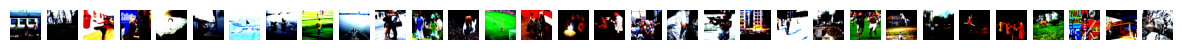

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8508403].
Clipp

torch.Size([64, 3, 224, 224])
Caption: A streetcar moves up a narrow road while a group of people gathers at the bottom of the hill.
torch.Size([64, 3, 224, 224])
Caption: Two bicycles are standing behind two people sitting on the grass near a body of water.
torch.Size([64, 3, 224, 224])
Caption: A snowboarder jumps off of a ramp in the snowy mountains
torch.Size([64, 3, 224, 224])
Caption: Four young men are playing indoor basketball while one jumps to reach the ball.
torch.Size([64, 3, 224, 224])
Caption: A small boy rides on a playground toy while pointing to a slide.
torch.Size([64, 3, 224, 224])
Caption: A runner jogging on a city street past a SAMSUNG advertisement banner.
torch.Size([64, 3, 224, 224])
Caption: A woman wearing a black and white shirt, glasses and has a ring on her right hand, is smiling, while sitting on what appears to be a sofa with a blanket throw on the back of it.
torch.Size([64, 3, 224, 224])
Caption: A blond woman in a brown sweater is standing behind a co

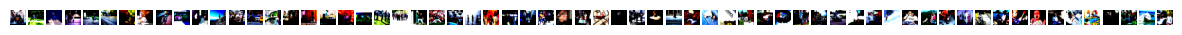

In [8]:
# dataset stats
print(f"Number of training samples: {len(train_dataloader.dataset)}")
print(f"Number of test samples: {len(test_dataloader.dataset)}")

# plot some samples from the dataset
data_iter = iter(test_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_test, figsize=(15, 5))
for i in range(batch_size_test):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

data_iter = iter(train_dataloader)
batch = next(data_iter)
image_tensor = batch['pixel_values']
captions = batch['description']
fig, axs = plt.subplots(1, batch_size_train, figsize=(15, 5))
for i in range(batch_size_train):
    print(image_tensor.shape)
    img = image_tensor[i].cpu().permute(1, 2, 0).numpy()
    print('Caption:', captions[i])
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

## Initialize Tokenizer

In [9]:
special_tokens = [cfg.SpecialTokens.PAD, cfg.SpecialTokens.BOS, cfg.SpecialTokens.EOS]
if config["TOKENIZER_TYPE"] == cfg.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config["TOKENIZER_TYPE"] == cfg.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config["TOKENIZER_DATA_PATH"], filename_prefix=config["TOKENIZER_FILENAME_PREFIX"])
    
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}")

Tokenizer vocab size: 10042


## Configure Model

In [10]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)

Initialized CNN + CPTR Encoder


## Training code

In [11]:
class EarlyStopping:
    def __init__(self, patience, delta, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
    
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.verbose:
                    print("Stopping early as no improvement has been observed.")

In [12]:
def train_step(model: torch.nn.Module,
               config,
               dataloader: torch.utils.data.DataLoader,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch in dataloader:
        images = batch["pixel_values"].to(device)
        texts = batch["description"]

        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids']
        tokens = tokens.to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        attention_mask = get_causal_mask(T, device=device)
        padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)

        logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)


        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to a max norm of 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def train_step_accumulate(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               config,
               tokenizer,
               pad_idx: int,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               accumulation_steps: int,
               device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    accumulation_steps: Number of steps to accumulate gradients before updating the model.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0, 0
    
    # Reset gradients at the start
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
        images = batch["pixel_values"].to(device)
        texts = batch["description"]
        outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
        tokens = outputs['input_ids'].to(device)

        targets = tokens[:, 1:]
        decoder_inputs = tokens[:, :-1]
        T = decoder_inputs.size(1)
        
        logits, loss = model(
            images=images, 
            text_tokens=decoder_inputs, 
            attn_mask=get_causal_mask(T, device), 
            pad_mask=get_padding_mask(decoder_inputs, pad_idx, device), 
            targets=targets
        )

        # 3. Normalize loss to account for accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # 4. Optimizer Step (only every 'accumulation_steps')
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad() # Clear for next set

        train_loss += (loss.item() * accumulation_steps)

        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            pad_idx = tokenizer.get_padding_token_id()
            non_pad = targets != pad_idx
            acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
            train_acc += acc.item()
        
        if verbose:
            with torch.no_grad():
                # print produced tokens for debugging
                if epoch is not None and config.NUM_EPOCHS - epoch <= 1:  # print only for last 2 epochs
                    decoded_preds = tokenizer.decode_batched(preds) #[tokenizer.decode(preds[i].cpu().numpy()) for i in range(preds.size(0))]
                    decoded_targets = tokenizer.decode_batched(targets) #[tokenizer.decode(targets[i].cpu().numpy()) for i in range(targets.size(0))]
                    for dp, dt in zip(decoded_preds, decoded_targets):
                        print(f"Predicted: {dp} | Target: {dt}")
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_perplexity = torch.exp(torch.tensor(train_loss)).item()
    train_acc = train_acc / len(dataloader)
    return train_loss, train_perplexity, train_acc

def test_step(model: torch.nn.Module,
              config,
              dataloader: torch.utils.data.DataLoader,
              tokenizer,
              pad_idx: int,
              device: torch.device, epoch=None, verbose=False) -> Tuple[float, float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    model.eval()

    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        for batch in dataloader:
          images = batch["pixel_values"].to(device)
          texts = batch["description"]

          outputs = tokenizer.encode_batched(texts=texts, max_seq_length=(L+1))
          tokens = outputs['input_ids']
          tokens = tokens.to(device)
          tokens = tokens.to(device)

          targets = tokens[:, 1:]
          decoder_inputs = tokens[:, :-1]
          T = decoder_inputs.size(1)
          attention_mask = get_causal_mask(T, device=device)
          padding_mask = get_padding_mask(decoder_inputs, pad_idx, device=device)
        
          logits, loss = model(images=images, text_tokens=decoder_inputs, attn_mask=attention_mask, pad_mask=padding_mask, targets=targets)

          test_loss += loss.item()

          preds = logits.argmax(dim=-1)
          pad_idx = tokenizer.get_padding_token_id()
          non_pad = targets != pad_idx
          acc = ((preds == targets) & non_pad).sum() / non_pad.sum()
          test_acc += acc.item()
          
          if verbose:
            # print produced tokens for debugging
            if epoch is not None and config["NUM_EPOCHS"] - epoch <= 1:  # print only for last 2 epochs
              decoded_preds = tokenizer.decode_batched(preds)
              decoded_targets = tokenizer.decode_batched(targets)
              for dp, dt in zip(decoded_preds, decoded_targets):
                  print(f"Predicted: {dp} | Target: {dt}")

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_perplexity = torch.exp(torch.tensor(test_loss)).item()
    test_acc = test_acc / len(dataloader)
    return test_loss, test_perplexity, test_acc

def train(model: torch.nn.Module,
          config,
          tokenizer, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device,
          early_stop_patience: int,
          early_stop_delta: float) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_perplexity: [...],
              train_acc: [...],
              test_loss: [...],
              test_perplexity: [...],
              test_acc: [...]} 
    """
    results = {"train_loss": [],
               "train_perplexity": [],
               "train_acc": [],
               "test_loss": [],
               "test_perplexity": [],
               "test_acc": []
    }
    
    model.to(device)
    
    pad_idx = tokenizer.get_padding_token_id()
    early_stopping = EarlyStopping(patience=early_stop_patience, delta=early_stop_delta, verbose=True)

    for epoch in tqdm(range(epochs)):
        if config["USE_ACCUMULATED_GRADIENTS"]:
            train_loss, train_perplexity, train_acc = train_step_accumulate(model=model,
                                              config=config,
                                              dataloader=train_dataloader,
                                              tokenizer=tokenizer,
                                              pad_idx=pad_idx,
                                              optimizer=optimizer,
                                              scheduler=scheduler,
                                              accumulation_steps=config["ACCUMULATION_STEPS"],
                                              device=device,
                                              epoch=epoch)
        else:
          train_loss, train_perplexity, train_acc = train_step(model=model,
                                            config=config,
                                            dataloader=train_dataloader,
                                            tokenizer=tokenizer,
                                            pad_idx=pad_idx,
                                            optimizer=optimizer,
                                            scheduler=scheduler,
                                            device=device,
                                            epoch=epoch)
        test_loss, test_perplexity, test_acc = test_step(model=model,
                                                         config=config,
                                                         dataloader=test_dataloader,
                                                         tokenizer=tokenizer,
                                                         pad_idx=pad_idx,
                                                         device=device,
                                                         epoch=epoch)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_perplexity: {train_perplexity:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_perplexity: {test_perplexity:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_perplexity"].append(train_perplexity)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_perplexity"].append(test_perplexity)
        results["test_acc"].append(test_acc)

        early_stopping.check_early_stop(test_loss)
        if early_stopping.stop_training:
            break
    
    return results

In [13]:
# freeze/unfreeze encoder weights
def config_encoder_params(model, requires_grad: bool):
    if config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_RESNET50:
        if requires_grad == True:
            for layer in model.encoder.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.parameters():
                param.requires_grad = requires_grad
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_BASE or config["ENCODER_ARCH"] == cfg.EncoderArch.VIT_STYLE_LARGE:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad
    elif config["ENCODER_ARCH"] == cfg.EncoderArch.CNN_CPTR_STYLE:
        if requires_grad == True:
            for layer in model.encoder.patcher.backbone[-2:]:  # unfreeze last 2 residual blocks
                for param in layer.parameters():
                    param.requires_grad = True
        else:
            for param in model.encoder.patcher.parameters():
                param.requires_grad = requires_grad
    else:
        for param in model.encoder.parameters():
            param.requires_grad = requires_grad

In [14]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    config_encoder_params(transformer, requires_grad=False)
    
    optimizer = torch.optim.AdamW(
        [p for p in transformer.parameters() if p.requires_grad],
        lr=config["LR"],
        weight_decay=0.01
    )
    
    if config["USE_ACCUMULATED_GRADIENTS"]:
        effective_steps_per_epoch = len(train_dataloader) // config["ACCUMULATION_STEPS"]
        # Account for the possible partial batch at the end
        if len(train_dataloader) % config["ACCUMULATION_STEPS"] != 0:
            effective_steps_per_epoch += 1
    else:
        effective_steps_per_epoch = len(train_dataloader)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["LR"], 
        steps_per_epoch=effective_steps_per_epoch, 
        epochs=config["NUM_FREEZE_EPOCHS"],
        pct_start=0.1 # 10% of time spent warming up
    )

In [15]:
# Check which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.img_pos_embedding.pos_embedding: torch.Size([1, 49, 2048])
encoder.encoder_blocks.0.MHSA.in_proj_weight: torch.Size([6144, 2048])
encoder.encoder_blocks.0.MHSA.in_proj_bias: torch.Size([6144])
encoder.encoder_blocks.0.MHSA.out_proj.weight: torch.Size([2048, 2048])
encoder.encoder_blocks.0.MHSA.out_proj.bias: torch.Size([2048])
encoder.encoder_blocks.0.layer_norm_1.weight: torch.Size([2048])
encoder.encoder_blocks.0.layer_norm_1.bias: torch.Size([2048])
encoder.encoder_blocks.0.FFN.0.weight: torch.Size([8192, 2048])
encoder.encoder_blocks.0.FFN.0.bias: torch.Size([8192])
encoder.encoder_blocks.0.FFN.3.weight: torch.Size([2048, 8192])
encoder.encoder_blocks.0.FFN.3.bias: torch.Size([2048])
encoder.encoder_blocks.0.layer_norm_2.weight: torch.Size([2048])
encoder.encoder_blocks.0.layer_norm_2.bias: torch.Size([2048])
encoder.encoder_blocks.1.MHSA.in_proj_weight: torch.Size([6144, 2048])
encoder.encoder_blocks.1.MHSA.in_proj_bias: torch.Size([6144])
e

In [ ]:
if config["NUM_FREEZE_EPOCHS"] > 0:
    # Train the model for freezing phase
    results = train(model=transformer,
                    config=config,
                    tokenizer=tokenizer,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    epochs=config["NUM_FREEZE_EPOCHS"],
                    device=device,
                    early_stop_patience=config["EARLY_STOPPING_PATIENCE"],
                    early_stop_delta=config["EARLY_STOPPING_DELTA"])
    print('Completed freezing phase.')

 10%|█         | 1/10 [03:59<35:58, 239.85s/it]

Epoch: 1 | train_loss: 6.8590 | train_perplexity: 952.4166 | train_acc: 0.1008 | test_loss: 4.1674 | test_perplexity: 64.5464 | test_acc: 0.2582


In [ ]:
config_encoder_params(transformer, requires_grad=True)

optimizer = torch.optim.AdamW(
    [
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" not in n],
            'lr': config["LR"]
        },
        {
            'params': [p for n, p in transformer.named_parameters() if "encoder" in n],
            'lr': config["LR"] * 0.01
        }
    ],
    weight_decay=config["WEIGHT_DECAY"]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config["NUM_EPOCHS"],
    eta_min=1e-7
)

In [ ]:
# Recheck which parameters require gradients
params_with_grad = {name: param for name, param in transformer.named_parameters() if param.requires_grad}
print("Parameters requiring gradients:")
for name, param in params_with_grad.items():
    print(f"{name}: {param.shape}")

Parameters requiring gradients:
encoder.patcher.backbone.0.weight: torch.Size([64, 3, 7, 7])
encoder.patcher.backbone.1.weight: torch.Size([64])
encoder.patcher.backbone.1.bias: torch.Size([64])
encoder.patcher.backbone.4.0.conv1.weight: torch.Size([64, 64, 1, 1])
encoder.patcher.backbone.4.0.bn1.weight: torch.Size([64])
encoder.patcher.backbone.4.0.bn1.bias: torch.Size([64])
encoder.patcher.backbone.4.0.conv2.weight: torch.Size([64, 64, 3, 3])
encoder.patcher.backbone.4.0.bn2.weight: torch.Size([64])
encoder.patcher.backbone.4.0.bn2.bias: torch.Size([64])
encoder.patcher.backbone.4.0.conv3.weight: torch.Size([256, 64, 1, 1])
encoder.patcher.backbone.4.0.bn3.weight: torch.Size([256])
encoder.patcher.backbone.4.0.bn3.bias: torch.Size([256])
encoder.patcher.backbone.4.0.downsample.0.weight: torch.Size([256, 64, 1, 1])
encoder.patcher.backbone.4.0.downsample.1.weight: torch.Size([256])
encoder.patcher.backbone.4.0.downsample.1.bias: torch.Size([256])
encoder.patcher.backbone.4.1.conv1.wei

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Train the model for the rest of the epochs and save the training results to a dictionary
results = train(model=transformer,
                config=config,
                tokenizer=tokenizer,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                epochs=config["NUM_EPOCHS"],
                device=device,
                early_stop_patience=int(config["NUM_EPOCHS"]*0.1),
                early_stop_delta=config["EARLY_STOPPING_DELTA"])
print('Completed training.')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [04:28<00:00, 268.28s/it]

Epoch: 1 | train_loss: 4.1887 | train_perplexity: 65.9362 | train_acc: 0.2542 | test_loss: 4.1612 | test_perplexity: 64.1481 | test_acc: 0.2576
Completed training.


In [ ]:
# export training results to results directory
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
results_path = os.path.join(results_dir, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f)

time_string = time.strftime("%Y%m%d-%H%M%S")
# export model weights
model_path = os.path.join(results_dir, f'cptr_model_{time_string}.pth')
torch.save(transformer.state_dict(), model_path)

## Test caption generation

In [ ]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))

Initialized CNN + CPTR Encoder


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


Caption GT:  An elderly couple dance in front of a juke box while a guy in shorts sleeps at a nearby table
Input image shape: torch.Size([1, 3, 224, 224])


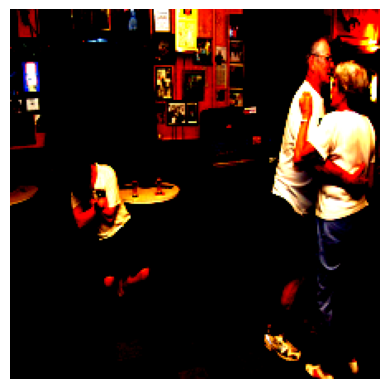

Generated token ids: tensor([  1,  68, 303, 270, 259, 113, 103, 259, 113, 103, 259, 113, 103, 259,
        113, 103, 259, 113, 103, 259, 113, 103, 259, 113, 103, 259, 113, 103,
        259, 113, 103, 259, 113, 103, 259, 113, 103, 259, 113, 103, 259, 113,
        103, 259, 113, 103, 259, 113, 103, 259, 113, 103, 259, 113, 103, 259,
        113, 103, 259, 113, 103, 259, 113, 103, 259, 113, 103, 259, 113, 103,
        259, 113, 103, 259, 113, 103, 259, 113, 103])
torch.Size([79])
Generated caption: <bos>A man in and and and and and and and and and and and and and and and and and and and and and and and and and


In [ ]:
transformer.eval()

batch = next(iter(test_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
print('Generated token ids:', tokens)
print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('Generated caption:', decoded_caption)